<table>
    <tr>
        <td><img src="./img/Macc.png" width="auto"/></td>
        <td>
            <table><tr>
            <h1 style="color:blue;text-align:center">Lógica para Ciencias de la Computación</h1></td>
            </tr></table>   
        <td>&nbsp;</td>
        <td>
            <table><tr>
            <tp><p style="font-size:150%;text-align:center">Taller</p></tp>
            <tp><p style="font-size:150%;text-align:center">Comparación de tiempos</p></tp>
            </tr></table>
        </td>
    </tr>
</table>

---

# Objetivo <a class="anchor" id="inicio"></a>

Compararemos los distintos SATsolvers que hemos visto en clase e incluiremos uno adicional que implementa un método optimizado, llamado [Minisat22](https://pysathq.github.io/docs/html/api/solvers.html).

Desarrollaremos la presentación de la siguiente manera:

# Secciones

1. [Funciones auxiliares](#aux)
2. [Comparación casos particulares](#comp1)
3. [Comparación dpll vs. Minisat22](#comp2)
4. [Análisis de casos en $k$-fnc](#comp3)


# Funciones auxiliares <a class="anchor" id="aux"></a>

([Volver al inicio](#inicio))



### Comparación de tiempos 

In [2]:
from time import time
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def obtiene_tiempos(fun, args, num_it=100):
    tiempos_fun = []
    resultados_fun = []
    for i in range(num_it):
        arranca = time()
        sat, I = fun(*args)
        para = time()
        tiempos_fun.append(para - arranca)
        resultados_fun.append(1 if sat=='Satisfacible' else 0)
    return tiempos_fun, resultados_fun

def compara_entradas_funs(funs, nombres_funs, lista_args, N=100):
    entradas = []
    funcion = []
    tiempos = []
    resultados = []
    lista_dfs = []
    for i, args in enumerate(lista_args):
        for j, fun in enumerate(funs):
            t, res = obtiene_tiempos(fun, [args], N)
            tiempos += t
            resultados += res
            entradas += [i+1]*len(t)
            funcion += [nombres_funs[j]]*len(t)
        df = pd.DataFrame({'Long_entrada':entradas, 
                           'Funcion':funcion,
                           'Tiempo_prom':tiempos,
                           'Resultados':resultados})
        lista_dfs.append(df)
    return pd.concat(lista_dfs).reset_index()
    
def compara_3kfnc(fun, nombre, n, m, lista_args, N=10):
    funcion = []
    alfa = []
    ns = []
    tiempos = []
    resultados = []
    lista_dfs = []
    for i, args in enumerate(lista_args):
        t, res = obtiene_tiempos(fun, [args], N)
        funcion += [nombre]*len(t)
        tiempos += t
        resultados += res
        alfa += [m/n]*len(t)
        ns += [n]*len(t)
        df = pd.DataFrame({'Funcion':funcion,
                           'alfa':alfa,
                           '#letras':ns,
                           'Tiempo_prom':tiempos,
                           'Resultados':resultados
                          })
        lista_dfs.append(df)
    df = pd.concat(lista_dfs).reset_index()
    return df

### Creación de cadenas aleatorias

In [25]:
def aumentar_cadena(c, condicion, atomos):

	if c == None:
		print('No se puede aumentar la cadena: atomos insuficientes?')
		return None

	if condicion == 'A':

		atomo = ''
		for a in atomos:
			if a not in c:
				atomo = a
				break

		if atomo == '':
			return None

		# aumenta cadena siguiendo condicion A
		return c + [atomo, 'Y']

	if condicion == 'B':
		# encuentra letra no usada en atomos y primer atomo
		atomo1 = ''
		atomo2 = ''
		for a in atomos:
			if a in c:
				if atomo1 == '':
					atomo1 = a
			else:
				atomo2 = a
				if atomo1 != '':
					break

		if atomo1 == '' or atomo2 == '':
			return None

		# aumenta cadena siguiendo condicion B
		return c + [atomo1, atomo2, 'O', 'Y']

	if condicion == 'C':
		# encuentra los dos atomos
		atomo1 = atomos[0]
		atomo2 = atomos[1]

		# aumenta cadena siguiendo condicion C
		return c + [atomo1, atomo2, 'Y', 'O']

	if condicion == 'D':
		# encuentra letra no usada en atomos y primer atomo
		atomo1 = ''
		atomo2 = ''
		for a in atomos:
			if a in c:
				if atomo1 == '':
					atomo1 = a
			else:
				atomo2 = a
				if atomo1 != '':
					break

		if atomo1 == '' or atomo2 == '':
			return None

		# aumenta cadena siguiendo condicion D
		return [atomo1] + c + [atomo2, 'Y', 'O']

### Satsolver estado del arte

La siguiente es la adaptación a nuestro entorno de uno de los SATsolver de estado del arte, llamado Minisat22. Observe que este solver trabaja sobre números y no sobre caracteres, por lo que es necesario hacer una especie de traducción usando `ord` y `chr`.

In [20]:
# !pip install python-sat
from pysat.solvers import Solver, Minisat22

def SATsolver(A):
    
    def lit_numero(l):
        if '-' in l:
            return -ord(l[1:]) + 256
        else:
            return ord(l) - 256
    
    def clausula_numero(C):
        return [lit_numero(l) for l in C]

    def fnc_numero(S):
        return [clausula_numero(C) for C in S]

    def obtener_int(mod):
        return {chr(256 + abs(n)):n>0 for n in mod}
        
    S = tseitin(A)
    S = fnc_numero(S)
    with Minisat22(bootstrap_with=S) as m:
        if m.solve():
            return 'Satisfacible', obtener_int(m.get_model())
        else:
            return 'Insatisfacible', {}

---

# Comparación casos particulares <a class="anchor" id="comp1"></a>

([Volver al inicio](#inicio))

Compararemos los solvers con respecto a cuatro tipos de series de fórmulas:

* Condición A: aumenta el número de $\wedge$s y de letras proposicionales.

* Condición B: aumenta el número de cláusulas en una fórmula en FNC.

* Condición C: aumenta el número de cláusulas en una fórmula en FND.

* Condición D: aumenta el número de fórmulas intercambiando $\wedge$ y $\vee$ con la fórmula y los literales.

### Condición A

In [30]:
from Logica import *

cantidad = 15
letrasp = [chr(i) for i in range(257, 257+cantidad)]

cnd = 'A'
lista = []

print('\n**********************')
print(u"Condición:", cnd)
cadena = [letrasp[0], letrasp[1], 'Y']
for i in range(1, len(letrasp)):
#    print('\n**********************')
#    print(u"Iteración:", i)
    cadena = aumentar_cadena(cadena, cnd, letrasp)
#    print(cadena)
    if cadena != None:
        A = polaca_inversa_to_tree(cadena, letrasp)
#        print('Trabajando con: ', A)
        lista.append(str(A))
    
print(lista[:3])


**********************
Condición: A
['(ăY(ĂYā))', '(ĄY(ăY(ĂYā)))', '(ąY(ĄY(ăY(ĂYā))))']


<AxesSubplot:xlabel='Long_entrada', ylabel='Tiempo_prom'>

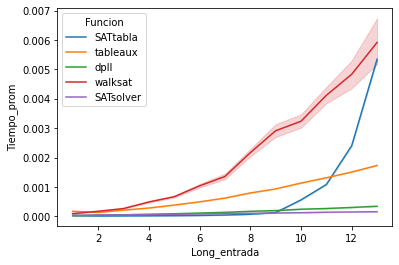

In [31]:
nombres = ['SATtabla', 'tableaux', 'dpll', 'walksat', 'SATsolver']
tabla = lambda formula: inorder_to_tree(formula).SATtabla()
tableaux = lambda formula: inorder_to_tree(formula).SATtableaux()
sat_dpll = lambda formula: dpll(tseitin(formula), {})
sat_walksat = lambda formula: walkSAT(tseitin(formula))
funs = [tabla, tableaux, sat_dpll, sat_walksat, SATsolver]
df = compara_entradas_funs(funs, nombres, lista)
sns.lineplot(x='Long_entrada',y='Tiempo_prom',hue='Funcion',data=df)

### Condición B

In [32]:
from Logica import *

cantidad = 15
letrasp = [chr(i) for i in range(257, 257+cantidad)]

cnd = 'B'
lista = []

print('\n**********************')
print(u"Condición:", cnd)
cadena = [letrasp[0], letrasp[1], 'Y']
for i in range(1, len(letrasp)):
#    print('\n**********************')
#    print(u"Iteración:", i)
    cadena = aumentar_cadena(cadena, cnd, letrasp)
#    print(cadena)
    if cadena != None:
        A = polaca_inversa_to_tree(cadena, letrasp)
#        print('Trabajando con: ', A)
        lista.append(str(A))

print(lista[:3])


**********************
Condición: B
['((ăOā)Y(ĂYā))', '((ĄOā)Y((ăOā)Y(ĂYā)))', '((ąOā)Y((ĄOā)Y((ăOā)Y(ĂYā))))']


<AxesSubplot:xlabel='Long_entrada', ylabel='Tiempo_prom'>

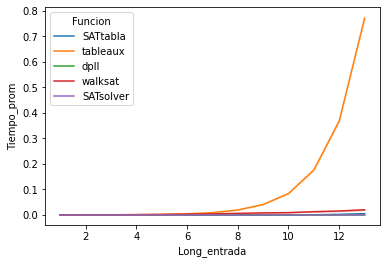

In [33]:
nombres = ['SATtabla', 'tableaux', 'dpll', 'walksat', 'SATsolver']
tabla = lambda formula: inorder_to_tree(formula).SATtabla()
tableaux = lambda formula: inorder_to_tree(formula).SATtableaux()
sat_dpll = lambda formula: dpll(tseitin(formula), {})
sat_walksat = lambda formula: walkSAT(tseitin(formula))
funs = [tabla, tableaux, sat_dpll, sat_walksat, SATsolver]
df = compara_entradas_funs(funs, nombres, lista)
sns.lineplot(x='Long_entrada',y='Tiempo_prom',hue='Funcion',data=df)

### Condición C

In [34]:
from Logica import *

cantidad = 15
letrasp = [chr(i) for i in range(257, 257+cantidad)]

cnd = 'C'
lista = []

print('\n**********************')
print(u"Condición:", cnd)
cadena = [letrasp[0], letrasp[1], 'Y']
for i in range(1, len(letrasp)):
#    print('\n**********************')
#    print(u"Iteración:", i)
    cadena = aumentar_cadena(cadena, cnd, letrasp)
#    print(cadena)
    if cadena != None:
        A = polaca_inversa_to_tree(cadena, letrasp)
#        print('Trabajando con: ', A)
        lista.append(str(A))
    
print(lista[:3])


**********************
Condición: C
['((ĂYā)O(ĂYā))', '((ĂYā)O((ĂYā)O(ĂYā)))', '((ĂYā)O((ĂYā)O((ĂYā)O(ĂYā))))']


<AxesSubplot:xlabel='Long_entrada', ylabel='Tiempo_prom'>

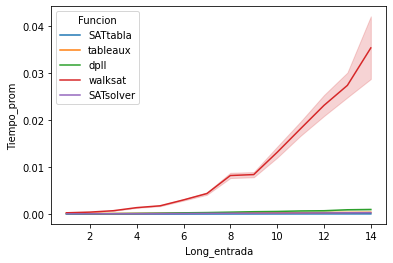

In [35]:
nombres = ['SATtabla', 'tableaux', 'dpll', 'walksat', 'SATsolver']
tabla = lambda formula: inorder_to_tree(formula).SATtabla()
tableaux = lambda formula: inorder_to_tree(formula).SATtableaux()
sat_dpll = lambda formula: dpll(tseitin(formula), {})
sat_walksat = lambda formula: walkSAT(tseitin(formula))
funs = [tabla, tableaux, sat_dpll, sat_walksat, SATsolver]
df = compara_entradas_funs(funs, nombres, lista)
sns.lineplot(x='Long_entrada',y='Tiempo_prom',hue='Funcion',data=df)

### Condición D

In [36]:
from Logica import *

cantidad = 15
letrasp = [chr(i) for i in range(257, 257+cantidad)]

cnd = 'D'
lista = []

print('\n**********************')
print(u"Condición:", cnd)
cadena = [letrasp[0], letrasp[1], 'Y']
for i in range(1, len(letrasp)):
#    print('\n**********************')
#    print(u"Iteración:", i)
    cadena = aumentar_cadena(cadena, cnd, letrasp)
#    print(cadena)
    if cadena != None:
        A = polaca_inversa_to_tree(cadena, letrasp)
#        print('Trabajando con: ', A)
        lista.append(str(A))
    
print(lista[:3])


**********************
Condición: D
['((ăY(ĂYā))Oā)', '((ĄY((ăY(ĂYā))Oā))Oā)', '((ąY((ĄY((ăY(ĂYā))Oā))Oā))Oā)']


<AxesSubplot:xlabel='Long_entrada', ylabel='Tiempo_prom'>

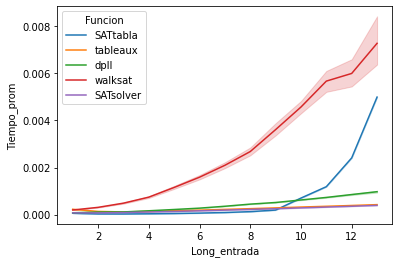

In [37]:
nombres = ['SATtabla', 'tableaux', 'dpll', 'walksat', 'SATsolver']
tabla = lambda formula: inorder_to_tree(formula).SATtabla()
tableaux = lambda formula: inorder_to_tree(formula).SATtableaux()
sat_dpll = lambda formula: dpll(tseitin(formula), {})
sat_walksat = lambda formula: walkSAT(tseitin(formula))
funs = [tabla, tableaux, sat_dpll, sat_walksat, SATsolver]
df = compara_entradas_funs(funs, nombres, lista)
sns.lineplot(x='Long_entrada',y='Tiempo_prom',hue='Funcion',data=df)

---

# Comparación dpll vs. Minisat22 <a class="anchor" id="comp2"></a>

([Volver al inicio](#inicio))



In [43]:
from random import uniform, choice

cantidad = 20
letras = [chr(i) for i in range(257, 257+cantidad)]
lista = [letras[0]]
formula = letras[0]
for p in letras[1:]:
            neg1 = '-' if uniform(0,1) < .5 else ''
            neg2 = '-' if uniform(0,1) < .5 else ''
            neg3 = '-' if uniform(0,1) < .5 else ''
            conectivo = choice(['Y','O','>'])
            if uniform(0,1) < .5:
                formula = neg1 + "(" + neg2 + formula + conectivo + neg3 + p + ")"
            else:
                formula = neg1 + "(" + neg2 + p + conectivo + neg3 + formula + ")"
            lista.append(formula)

<AxesSubplot:xlabel='Long_entrada', ylabel='Tiempo_prom'>

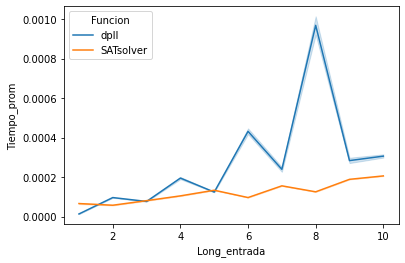

In [42]:
nombres = ['dpll', 'SATsolver']
sat_dpll = lambda formula: dpll(tseitin(formula), {})
funs = [sat_dpll, SATsolver]
df = compara_entradas_funs(funs, nombres, lista)
sns.lineplot(x='Long_entrada',y='Tiempo_prom',hue='Funcion',data=df)

---

# Fórmulas $k$-FNC <a class="anchor" id="comp3"></a>

([Volver al inicio](#inicio))

Una fórmula $k$k-FNC $A$ es una fórmula en forma normal conjuntiva con $n$ letras proposicionales generadas al crear de manera independiente $m$ cláusulas. El proceso de creación es el siguiente: repetir $m$ veces el proceso de creación de una cláusula aleatoria, para la cual se escogen aleatoriamente $k$ letras proposicionales con igual probabilidad y cada una se niega con probabilidad 0.5.




In [44]:
from random import sample, uniform

def k_fnc_formula(k, n, m):
    assert(k<=n), "¡k inválido!"
    letrasp = [chr(x) for x in range(257, 257 + n)]
    formula = []
    for i in range(m):
        vs = sample(letrasp, k)
        negs = ['-' if uniform(0,1) < .5 else '' for i in range(k)]
        formula.append([negs[i] + vs[i] for i in range(k)])
    return formula

In [45]:
k_fnc_formula(3, 10, 2)

[['-ă', '-Ă', 'ā'], ['ĉ', '-Ă', '-Ć']]

$\alpha=\frac{m}{n}$

Proporción de número de cláusulas sobre número de letras proposicionales.

In [46]:
import numpy as np

def obtiene_complejidad(fun, nombre):
    lista_dfs = []
    for n in [20, 40, 50]:
        alfas = np.arange(2.0, 8.25, 0.25).tolist()
        for alfa in alfas:
            m = int(n * alfa)
            lista = [k_fnc_formula(3, n, m) for i in range(10)]
            lista_dfs.append(compara_3kfnc(fun, nombre, n, m, lista))
    return pd.concat(lista_dfs).reset_index()


In [47]:
from Logica import *
nombre = 'dpll'
fun = lambda formula: dpll(formula, {})
df = obtiene_complejidad(fun, nombre)

Text(0.5, 0.98, 'dpll')

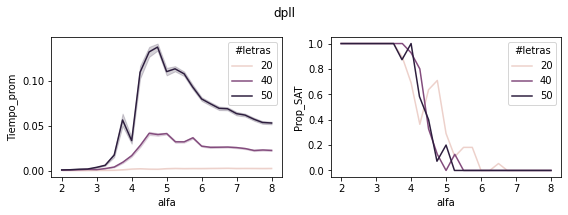

In [48]:
fig, ax = plt.subplots(1,2,figsize=(8,3), tight_layout=True)
sns.lineplot(x='alfa',y='Tiempo_prom',hue='#letras',data=df,ax=ax[0])
df_prop = df.groupby(['#letras','alfa'])['Resultados'].mean().reset_index(name='Prop_SAT')
sns.lineplot(x='alfa',y='Prop_SAT',hue='#letras',data=df_prop,ax=ax[1])
fig.suptitle(nombre)

En la gráfica de la izquierda se observa que los tiempos de ejecución muestran un patrón fácil-difícil-fácil a medida que aumenta $\alpha$. Las cláusulas más fáciles para el satsolver son aquellas que tienen un alfa menor a 3, es decir, que el número de cláusulas es la tercera parte del número de letras proposicionales. Alrededor de $\alpha=4$ se observa una especie de "cambio de fase" en la cual la dificultad de la fórmula (tiempo de ejecución) aumenta, para luego comenzar a disminuir.

De acuerdo a la gráfica de la derecha, observamos que las fórmulas con un $\alpha$ menor a 4 son casi siempre satisfacibles, y que las fórmulas con un $\alpha$ superior a 5 son casi siempre insatisfacibles. Note que la dificultad de una fórmula no está relacionada directamente con ser insatisfacible, sino con la proporción $\alpha$.

---